In [196]:
#Install pytorch only the first time you run
# conda install pytorch torchvision -c pytorch

In [4]:
#IMPORT NEEDED packages
import torch
import torchvision
import torchsummary
from torchsummary import summary

Defino los parametros del entrenamiento

In [5]:
# SET PARAMETERS
n_epochs = 10
batch_size_train = 64 #def:64
batch_size_test = 1000  #def: 1000
learning_rate = 0.01  #def: 0.01
momentum = 0.05   # default 0.5
log_interval = 50

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Voy a bajar la base de datos de numeros manuscritos MNIST con torchvision y luego se los paso al DataLoader de pytorch. Le defino el batch_size y el shuffle.

In [6]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1186667.64it/s]


Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 3111228.81it/s]


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1097354.69it/s]


Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 7240793.91it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw



Los datos estan en un iterador, si quiero tomar una muestra de los datos debo hacer:

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples) # tomo un dato

In [8]:
example_data.shape

torch.Size([1000, 1, 28, 28])

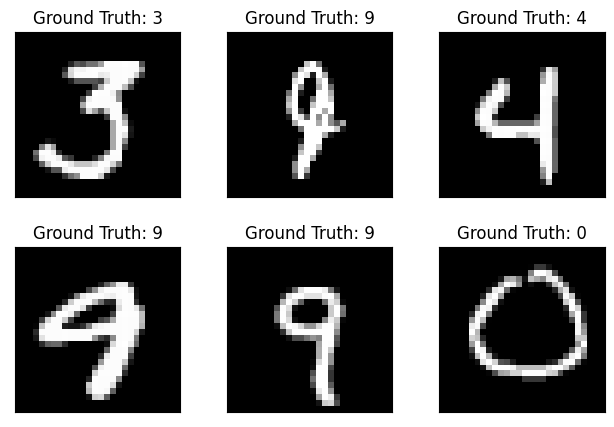

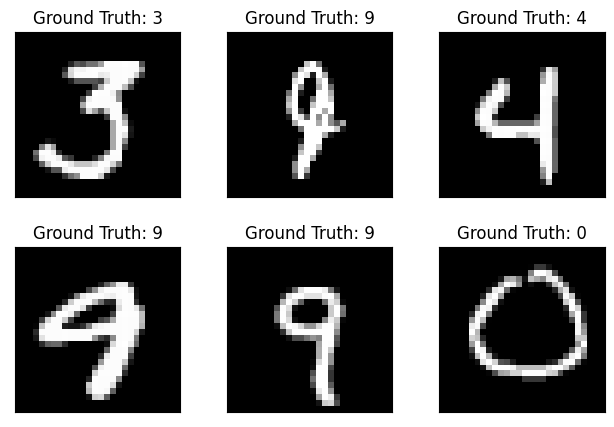

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Uso dos capas convolucionales y dos FC. Uso max pooling y relu.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5) #def 10
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5) #def 20
     #   self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*4*4, 1024) #def: 320, 50
        self.fc2 = nn.Linear(1024, 10)    #def: 50,10

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
      #  x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*4*4) # flattens x to [-1, 20*4*4=320]
        x = F.relu(self.fc1(x))
       # x = F.dropout(x, p=0.5,training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network = Net()  # Aqui estoy inicializando los parametros de la red en forma implicita (nn.Module).

optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) #default mini-batch SGD
#optimizer = optim.Adam(network.parameters(), lr=learning_rate) # ADAM optimizer


summary(network, (1, 28, 28))
#summary(network, input_size=([1000, 1, 28, 28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                 [-1, 1024]       1,049,600
            Linear-4                   [-1, 10]          10,250
Total params: 1,111,946
Trainable params: 1,111,946
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 4.24
Estimated Total Size (MB): 4.42
----------------------------------------------------------------


/tmp/ipykernel_12388/114346560.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
def train(epoch): # Hago una epoca de entrenamiento (barrido a lo largo de todos los datos de entrenamiento con batch_size)
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader): # cargo un batch de datos
    optimizer.zero_grad()   # inicializo los gradientes a 0
    output = network(data)  # predigo la red
    loss = F.nll_loss(output, target)  #negative loss likelihood loss = crossentropy
    loss.backward()   # hago backpropagation
    optimizer.step()  # hago descenso de gradientes
    if batch_idx % log_interval == 0: # hago validacion e impresion de  resultados
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [15]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad(): # NO requiero calcular gradientes para validacion
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item() # Calcula con los 1000 datos
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [16]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_12388/114346560.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/pulido/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3002, Accuracy: 1443/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294559


RuntimeError: Parent directory results does not exist.

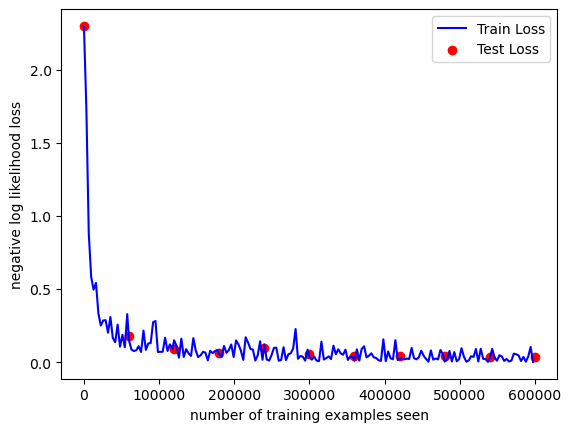

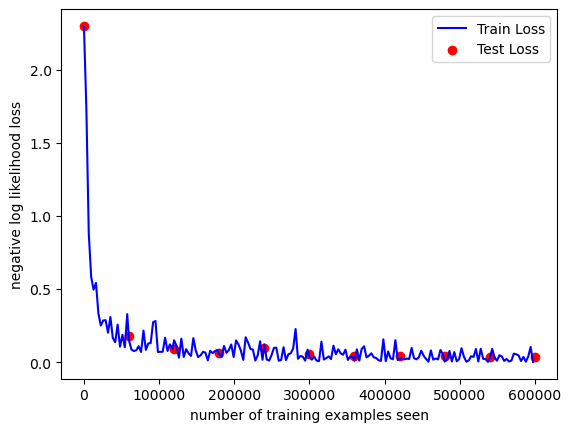

In [210]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [211]:
with torch.no_grad():
  output = network(example_data)


/var/folders/2r/yydhrl7x4rggzjddrp71v4hh0000gn/T/ipykernel_72462/114346560.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


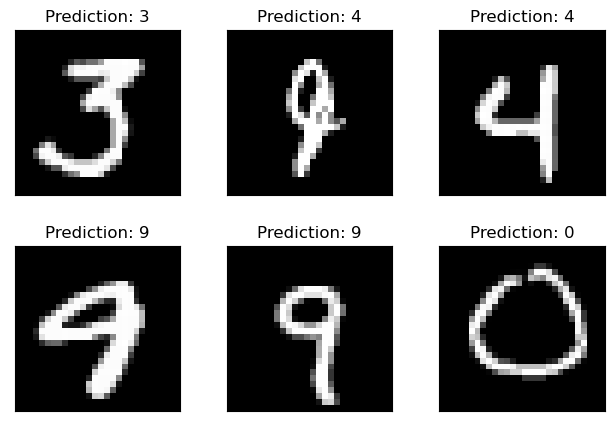

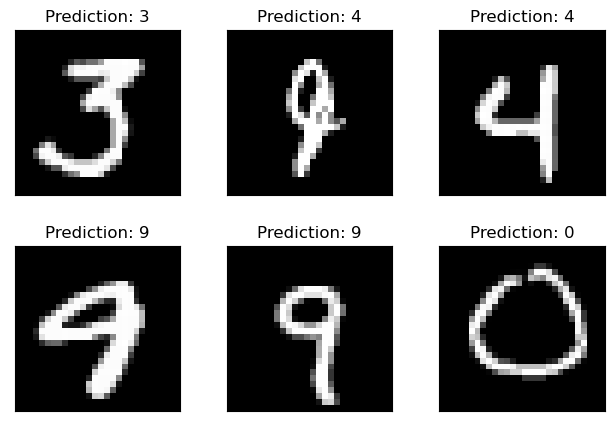

In [212]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig